## TFL Oyster Card Journeys Analysis
London is a major world capital in many sectors, though perhaps most notably in finance. With a booming economy, people are flocking to the city from all around the world, attracting by the thriving job market and high standards of living.
This has caused its population to increase steadily and consistently since the 1970s, and most notably since the 1990s.
> ... London’s population rising from 8.2 million in 2011, to:
>
>9.20 million in 2021;
>9.54 million in 2026;
>9.84 million in 2031; and
>10.11 million in 2036.


With a growing population, London's roads are becoming more congested and the TFL network is struggling to cope. Never was this more obvious than at the height of the COVID-19 crisis in early March this year.

In this notebook I will analyse a dataset containing information on TFL Oyster card journeys across a 7-day period in November 2009 to draw some insights on the TFL network to highlight the key problem areas that need to be addressed.


<figure>
   <a href="https://www.london.gov.uk/sites/default/files/styles/gla_large_unconstrained/public/figure_1.1_annual_pop_change_1971-2011.png?itok=tmztWl0e">
   <img src=https://www.london.gov.uk/sites/default/files/styles/gla_large_unconstrained/public/figure_1.1_annual_pop_change_1971-2011.png?itok=tmztWl0e width="500" align="center"/></a>
   <figcaption> London population change between 1971-2011. Source: london.gov.uk
   </figcaption>
</figure>

In [1]:
# import modules
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


C:\Users\Manager\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Read in dataset
df = pd.read_csv('Nov09JnyExport.csv')

In [3]:
# Check the head of the dataset
df.head()

,downo,daytype,SubSystem,StartStn,EndStation,EntTime,EntTimeHHMM,ExTime,EXTimeHHMM,ZVPPT,JNYTYP,DailyCapping,FFare,DFare,RouteID,FinalProduct
0,3,Tue,LUL,Unstarted,Kings Cross M,0,00:00,633,10:33,Z0104,TKT,N,0,0,XX,LUL Travelcard-7 Day
1,4,Wed,LUL,Unstarted,Sudbury Hill,0,00:00,447,07:27,Z0110,TKT,N,0,0,XX,Freedom Pass (Elderly)
2,3,Tue,NR,Unstarted,Richmond,0,00:00,966,16:06,Z0304,TKT,N,0,0,XX,LUL Travelcard-7 Day
3,4,Wed,NR,Unstarted,Romford,0,00:00,657,10:57,Z0110,TKT,N,0,0,XX,Freedom Pass (Elderly)
4,6,Fri,NR,Unstarted,Norwood Junction SR,0,00:00,450,07:30,Z0104,TKT,N,0,0,XX,LUL Travelcard-7 Day


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2623487 entries, 0 to 2623486
Data columns (total 16 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   downo         int64 
 1   daytype       object
 2   SubSystem     object
 3   StartStn      object
 4   EndStation    object
 5   EntTime       int64 
 6   EntTimeHHMM   object
 7   ExTime        int64 
 8   EXTimeHHMM    object
 9   ZVPPT         object
 10  JNYTYP        object
 11  DailyCapping  object
 12  FFare         int64 
 13  DFare         int64 
 14  RouteID       object
 15  FinalProduct  object
dtypes: int64(5), object(11)
memory usage: 320.2+ MB


# Step 1: Data Wrangling
* First off,Clean up and reformat the data to make it suit my purposes.
* I'll start by renaming some columns to make them more descriptive and consistent.

In [5]:
df = df.rename(columns={'downo': 'DOWno', 'daytype': 'DOW', 'EndStation': 'EndStn',
                        'EXTimeHHMM': 'ExTimeHHMM', 'ZVPPT': 'Zones', 'JNYTYP': 'JourneyType',
                        'FFare': 'FullFare', 'DFare': 'DiscountFare', 'RouteID': 'BusRoute'})

In [6]:
df['EntTimeHHMM'].value_counts()

00:00    45989
08:12     4429
08:16     4391
08:09     4334
08:10     4334
         ...  
27:25       56
04:31       52
26:36       50
01:42        1
04:08        1
Name: EntTimeHHMM, Length: 1443, dtype: int64

In [7]:
df['ExTimeHHMM'].value_counts()

00:00    1812168
08:59       1962
08:48       1912
08:49       1865
08:50       1859
          ...   
04:40          1
26:14          1
02:37          1
05:12          1
05:19          1
Name: ExTimeHHMM, Length: 1230, dtype: int64

* By far the most frequent value for both 'EntTimeHHMM' and 'ExTimeHHMM' is 00:00
* This appears erroneous, as one would expect that most passengers would travel at rush hour (before 9am, after 5pm)
* I will inspect this further and possibly drop these two columns, as the 'EntTime' and 'ExTime' columns supply sufficient information (time in minutes after midnight)

In [8]:
df[df['EntTimeHHMM'] != '00:00']['EntTimeHHMM'].value_counts().head(30)

08:12    4429
08:16    4391
08:10    4334
08:09    4334
08:19    4322
08:14    4296
08:13    4276
08:05    4271
08:07    4264
08:15    4256
08:08    4243
08:11    4242
08:17    4233
08:06    4191
08:04    4187
08:21    4182
17:09    4158
17:11    4139
08:01    4133
17:08    4128
08:24    4124
08:02    4092
17:07    4087
08:20    4084
08:22    4084
17:42    4074
08:27    4061
08:03    4050
08:26    4049
17:10    4048
Name: EntTimeHHMM, dtype: int64

In [9]:
df[df['EntTimeHHMM'] != '00:00']['EntTimeHHMM'].value_counts().tail(30)

27:47    72
27:49    72
26:46    72
25:58    72
27:17    71
27:01    71
26:26    71
26:06    70
26:53    69
26:48    69
27:51    69
27:37    68
27:36    68
26:28    67
26:40    67
27:44    66
27:08    66
26:34    65
27:58    65
27:43    65
26:51    63
27:35    62
27:11    62
26:45    60
27:27    60
27:25    56
04:31    52
26:36    50
04:08     1
01:42     1
Name: EntTimeHHMM, dtype: int64

In [10]:
df[df['EntTimeHHMM'] == '27:25']

,DOWno,DOW,SubSystem,StartStn,EndStn,EntTime,EntTimeHHMM,ExTime,ExTimeHHMM,Zones,JourneyType,DailyCapping,FullFare,DiscountFare,BusRoute,FinalProduct
951615,5,Thu,LTB,Bus,Bus,1645,27:25,0,00:00,-------,PPY,Y,100,30,N35,PAYG
951616,5,Thu,LTB,Bus,Bus,1645,27:25,0,00:00,B0104,TKT,N,0,0,N27,Bus & Tram Pass-7 Day
951617,6,Fri,LTB,Bus,Bus,1645,27:25,0,00:00,B0104,TKT,N,0,0,N3,Bus & Tram Pass-7 Day
951618,7,Sat,LTB,Bus,Bus,1645,27:25,0,00:00,Z0203,TKT,N,0,0,188,LUL Travelcard-1 Month
951619,4,Wed,LTB,Bus,Bus,1645,27:25,0,00:00,-------,PPY,N,100,100,N189,PAYG
951620,6,Fri,LTB,Bus,Bus,1645,27:25,0,00:00,-------,PPY,N,100,100,N102,PAYG
951621,4,Wed,LTB,Bus,Bus,1645,27:25,0,00:00,B0104,TKT,N,0,0,N25,Bus & Tram Pass-7 Day
951622,1,Sun,LTB,Bus,Bus,1645,27:25,0,00:00,Z0203,TKT,N,0,0,N18,LUL Travelcard-7 Day
951623,2,Mon,LTB,Bus,Bus,1645,27:25,0,00:00,Z0203,TKT,N,0,0,N18,LUL Travelcard-7 Day
951624,3,Tue,LTB,Bus,Bus,1645,27:25,0,00:00,B0104,TKT,N,0,0,N21,Bus & Tram Pass-7 Day


In [11]:
df[(df['EntTimeHHMM'] == '26:36')]

,DOWno,DOW,SubSystem,StartStn,EndStn,EntTime,EntTimeHHMM,ExTime,ExTimeHHMM,Zones,JourneyType,DailyCapping,FullFare,DiscountFare,BusRoute,FinalProduct
947808,6,Fri,LTB,Bus,Bus,1596,26:36,0,00:00,-------,PPY,N,0,0,N2,PAYG
947809,6,Fri,LTB,Bus,Bus,1596,26:36,0,00:00,B0104,TKT,N,0,0,N16,Bus & Tram Pass-7 Day
947810,4,Wed,LTB,Bus,Bus,1596,26:36,0,00:00,-------,PPY,N,100,100,N97,PAYG
947811,1,Sun,LTB,Bus,Bus,1596,26:36,0,00:00,Z0203,TKT,N,0,0,N87,LUL Travelcard-7 Day
947812,6,Fri,LTB,Bus,Bus,1596,26:36,0,00:00,B0104,TKT,N,0,0,N91,Bus & Tram Pass-7 Day
947813,7,Sat,LTB,Bus,Bus,1596,26:36,0,00:00,-------,PPY,N,100,100,N214,PAYG
947814,4,Wed,LTB,Bus,Bus,1596,26:36,0,00:00,Z0203,TKT,N,0,0,N86,LUL Travelcard-7 Day
947815,3,Tue,LTB,Bus,Bus,1596,26:36,0,00:00,-------,PPY,Y,100,0,N20,PAYG
947816,6,Fri,LTB,Bus,Bus,1596,26:36,0,00:00,Z0103,TKT,N,0,0,N279,LUL Travelcard-7 Day
947817,5,Thu,LTB,Bus,Bus,1596,26:36,0,00:00,-------,PPY,N,100,100,N98,PAYG


### Some observations on 'EntTimeHHMM' and 'ExTimeHHMM'
* As expected, the vast majority of journeys (excluding at default time of 00:00) happen between 08:00-09:00 or 17:00-18:00, which is rush hour in London
* All erroneous entries where HH > 23 are bus journeys on night bus routes (including 24-hour routes such as route 83), as evidenced in the tables above (e.g. N295 at index 947857)
* These two categories do not provide me with any unique insight that I cannot derive from the categories, such as 'EntTime' and 'ExTime', and they are altogether too convoluted. I will therefore drop both categories.

In [12]:
df = df.drop(['EntTimeHHMM', 'ExTimeHHMM'], axis=1)

* Now I'll check the entries for the remaining categories

In [13]:
# Bus by far most popular mode of transport (for oyster card journeys at least)
df['SubSystem'].value_counts()

LTB           1768080
LUL            723126
NR              47715
LUL/NR          25990
LUL/DLR         13911
TRAM             9583
DLR              9224
LUL/NR/LRC       8262
NR/LRC           6665
LRC              3713
LUL/LRC          3293
LUL/NR/DLR       2812
HEX               760
NR/DLR            263
LUL/TRAM           86
DLR/LRC             4
Name: SubSystem, dtype: int64

In [14]:
print(sorted(df['StartStn'].unique()))

['ADDISCOMBE TRAM               ', 'ADDNGTN VIL TRAM              ', 'AMPERE WAY TRAM               ', 'ARENA TRAM                    ', 'AVENUE ROAD TRAM              ', 'Acton Central', 'Acton Main Line', 'Acton Town', 'Aldgate', 'Aldgate East', 'All Saints', 'Alperton', 'Amersham', 'Angel', 'Archway', 'Arnos Grove', 'Arsenal', 'BECKENHM JN TRAM              ', 'BECKENHM RD TRAM              ', 'BEDDNGTN LN TRAM              ', 'BELGRAVE WK TRAM              ', 'BIRKBECK TRAM                 ', 'BLCKHRS LNE TRAM              ', 'Baker Street', 'Balham', 'Balham NR', 'Bank', 'Barbican', 'Barking', 'Barkingside', 'Barons Court', 'Battersea Park', 'Bayswater', 'Beckton', 'Beckton Park', 'Becontree', 'Bellingham', 'Belsize Park', 'Bermondsey', 'Bethnal Green', 'Bethnal Green NR', 'Blackfriars', 'Blackhorse Road', 'Blackwall', 'Bond Street', 'Borough', 'Boston Manor', 'Bounds Green', 'Bow Church', 'Bow Road', 'Brent Cross', 'Brixton', 'Brockley', 'Bromley By Bow', 'Brondesbury', 'Brondesb

In [15]:
print(sorted(df['EndStn'].unique()))

['Acton Central', 'Acton Main Line', 'Acton Town', 'Aldgate', 'Aldgate East', 'All Saints', 'Alperton', 'Amersham', 'Angel', 'Archway', 'Arnos Grove', 'Arsenal', 'Baker Street', 'Balham', 'Balham SCL', 'Bank', 'Barbican', 'Barking', 'Barkingside', 'Barons Court', 'Battersea Park', 'Bayswater', 'Beckton', 'Beckton Park', 'Becontree', 'Belsize Park', 'Bermondsey', 'Bethnal Green', 'Bethnal Green NR', 'Blackfriars', 'Blackhorse Road', 'Blackwall', 'Bond Street', 'Borough', 'Boston Manor', 'Bounds Green', 'Bow Church', 'Bow Road', 'Brent Cross', 'Brixton', 'Brockley', 'Bromley By Bow', 'Brondesbury', 'Brondesbury Park', 'Buckhurst Hill', 'Burnt Oak', 'Bus', 'Bushey', "Caledonian Rd&B'sby", 'Caledonian Road', 'Cambridge Heath', 'Camden Road', 'Camden Town', 'Canada Water', 'Canary Wharf', 'Canary Wharf DLR', 'Canary Wharf E2', 'Canning Town', 'Cannon Street', 'Canonbury', 'Canons Park', 'Carpenders Park', 'Carshalton', 'Castle Bar Park', 'Chalfont & Latimer', 'Chalk Farm', 'Chancery Lane', 

* Looking at the unique station names in 'StartStn', we can see that some passengers did not touch in, resulting in default station name 'Unstarted'
* Doing the same for 'EndStn', we find that journeys where the passenger did not touch out are given the default station name 'Unfinished'

## Completed Journeys
* I am interested in exploring journey length and how it interacts with other variables.
* In order to do this, I will now create a new dataframe called 'complete', which is a subset of 'df', but only containing entries where the passenger touched both in and out (i.e. we know both their start and end station).

In [16]:
complete = df[(df['StartStn'] != 'Unstarted') & (df['EndStn'] != 'Unfinished')]

In [17]:
complete.head()

,DOWno,DOW,SubSystem,StartStn,EndStn,EntTime,ExTime,Zones,JourneyType,DailyCapping,FullFare,DiscountFare,BusRoute,FinalProduct
45989,2,Mon,LUL,Goodge Street,Totteridge,1000,1041,Z0110,TKT,N,0,0,XX,Freedom Pass (Elderly)
45990,6,Fri,LTB,Bus,Bus,1000,0,Z0102,TKT,N,0,0,242,LUL Travelcard-7 Day
45991,5,Thu,LTB,Bus,Bus,1000,0,B0104,TKT,N,0,0,16,Bus & Tram Pass-1 Month
45992,6,Fri,LTB,Bus,Bus,1000,0,Z0203,TKT,N,0,0,254,LUL Travelcard-7 Day
45993,7,Sat,LTB,Bus,Bus,1000,0,-------,PPY,N,100,100,474,PAYG


In [18]:
complete.sample()

,DOWno,DOW,SubSystem,StartStn,EndStn,EntTime,ExTime,Zones,JourneyType,DailyCapping,FullFare,DiscountFare,BusRoute,FinalProduct
291799,1,Sun,LTB,Bus,Bus,1066,0,-------,PPY,N,100,100,134,PAYG


* Looking at subsets of 'complete', it is apparent that all bus journeys have a default Exit Time of midnight. This makes sense, as passengers are not required to touch out on bus journeys, so there will be no information on the end time of their journey. For our purposes, this is not helpful, as we are trying to look at journey times.
* A further observation is that for some bus journeys, the Start station and End station are both 'Bus' by default.
* For this reason, I will drop all bus journeys from the 'complete' subset.

In [19]:
# drop all bus journeys from complete
complete = complete[complete['SubSystem'] != 'LTB']

* As we have dropped all bus journeys, 'BusRoute' column is now redundant, as all entries will be 'XX' by default. I will now drop this column.

In [20]:
complete = complete.drop('BusRoute', axis=1)

### Feature engineering
Next I create a new category called "JourneyTime", which is the total journey time in minutes, as the difference between "ExTime" and "EntTime"

In [21]:
complete['JourneyLength'] = complete['ExTime'] - complete['EntTime']

In [22]:
complete[complete['JourneyLength'] <= 0]

,DOWno,DOW,SubSystem,StartStn,EndStn,EntTime,ExTime,Zones,JourneyType,DailyCapping,FullFare,DiscountFare,FinalProduct,JourneyLength
46362,2,Mon,TRAM,WADDON MARSH TRAM,Not Applicable,1000,0,Z0104,TKT,N,0,0,Bus & Tram Pass-1 Month,-1000
46516,7,Sat,TRAM,WELLESLY RD TRAM,Not Applicable,1000,0,Z0104,TKT,N,0,0,Bus & Tram Pass-7 Day,-1000
47399,3,Tue,TRAM,THERAPIA LN TRAM,Not Applicable,1000,0,-------,PPY,N,0,0,PAYG,-1000
47574,5,Thu,TRAM,THERAPIA LN TRAM,Not Applicable,1000,0,Z0110,TKT,N,0,0,Freedom Pass (Elderly),-1000
47682,2,Mon,TRAM,EAST CROYDON TRAM,Not Applicable,1000,0,-------,PPY,N,100,100,PAYG,-1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2623004,5,Thu,TRAM,EAST CROYDON TRAM,Not Applicable,999,0,-------,PPY,N,0,0,PAYG,-999
2623088,2,Mon,TRAM,ELMERS END TRAM,Not Applicable,999,0,Z0104,TKT,N,0,0,Bus & Tram Pass-7 Day,-999
2623225,6,Fri,TRAM,MORDEN ROAD TRAM,Not Applicable,999,0,Z0203,TKT,N,0,0,LUL Travelcard-7 Day,-999
2623443,6,Fri,TRAM,WIMBLEDON TRAM,Not Applicable,999,0,-------,PPY,N,0,0,PAYG,-999


* Looking at 'JourneyTime', we find that all Tram journeys follow the same pattern as Bus journeys, defaulting to an Exit Time of midnight. This is not helpful for our purposes, so I will now drop all Tram journeys.

In [23]:
complete = complete[complete['SubSystem'] != 'TRAM']

In [24]:
complete[complete['JourneyLength'] <= 0]

,DOWno,DOW,SubSystem,StartStn,EndStn,EntTime,ExTime,Zones,JourneyType,DailyCapping,FullFare,DiscountFare,FinalProduct,JourneyLength
48078,3,Tue,LUL,Oxford Circus,Oxford Circus,1000,1000,-------,PPY,N,0,0,PAYG,0
51353,3,Tue,LUL,Holborn,Holborn,1001,1001,-------,PPY,N,0,0,PAYG,0
51397,7,Sat,LUL,Notting Hill Gate,Notting Hill Gate,1001,1001,-------,PPY,N,400,400,PAYG,0
54697,3,Tue,LUL,Holborn,Holborn,1002,1002,-------,PPY,N,0,0,PAYG,0
59721,7,Sat,LUL,Balham,Balham,1004,1004,-------,PPY,N,0,0,PAYG,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2586350,7,Sat,LUL,Westminster,Westminster,988,988,-------,PPY,N,400,400,PAYG,0
2587209,5,Thu,NR,East Croydon,East Croydon,989,989,Z0110,TKT,N,0,0,Freedom Pass (Elderly),0
2587437,6,Fri,LUL,Stamford Brook,Stamford Brook,989,989,-------,PPY,N,400,400,PAYG,0
2592585,4,Wed,LUL/NR/DLR,Stratford,Stratford,990,990,-------,PPY,N,0,0,PAYG,0


In [25]:
complete[complete['JourneyLength'] <= 0].sample()

,DOWno,DOW,SubSystem,StartStn,EndStn,EntTime,ExTime,Zones,JourneyType,DailyCapping,FullFare,DiscountFare,FinalProduct,JourneyLength
906468,1,Sun,LUL,Leyton,Leyton,1419,1419,-------,PPY,N,0,0,PAYG,0


* Lastly, we find that there are 724 remaining entries where 'JourneyTime' is less than or equal to zero. These all appear to be where a passenger has touched in and out of the same station, so I now drop all entries where the Start Station and End Station are the same

In [26]:
complete = complete[complete['StartStn'] != complete['EndStn']]

In [27]:
complete[complete['JourneyLength'] <= 0]

,DOWno,DOW,SubSystem,StartStn,EndStn,EntTime,ExTime,Zones,JourneyType,DailyCapping,FullFare,DiscountFare,FinalProduct,JourneyLength
93546,7,Sat,NR,Balham NR,Balham SCL,1014,1014,Z0103,TKT,N,0,0,LUL Travelcard-1 Month,0
172562,2,Mon,LUL,Canary Wharf E2,Canary Wharf,1035,1035,-------,PPY,N,110,110,PAYG,0
211864,4,Wed,NR,Balham NR,Balham SCL,1045,1045,Z0104,TKT,N,0,0,LUL Travelcard-1 Month,0
282008,2,Mon,LUL,Southfields,Not Applicable,1064,967,-------,PPY,N,0,0,PAYG,-97
391984,5,Thu,NR,Liverpool St NR,Liverpool St WAGN TOC Gates,1094,1094,-------,PPY,N,0,0,PAYG,0
404334,7,Sat,LUL,Canary Wharf E2,Canary Wharf,1097,1097,Z0203,TKT,N,0,0,LUL Travelcard-7 Day,0
419315,5,Thu,LUL,Canary Wharf E2,Canary Wharf,1101,1101,Z0110,TKT,N,0,0,Freedom Pass (Elderly),0
530345,5,Thu,NR,Balham NR,Balham SCL,1139,1139,Z0103,TKT,N,0,0,LUL Travelcard-7 Day,0
560067,5,Thu,NR,Liverpool St NR,Liverpool St WAGN TOC Gates,1150,1150,-------,PPY,N,0,0,PAYG,0
566531,6,Fri,NR,Liverpool St NR,Liverpool St WAGN TOC Gates,1153,1153,-------,PPY,N,0,0,PAYG,0


In [28]:
print(f"Remaining invalid journey times: {len(complete[complete['JourneyLength'] <= 0])}")

Remaining invalid journey times: 46


* Lastly, we have 46 remaining entries where 'JourneyTime' is less than or equal to zero. These are all cases where the start and end station are the same, so I will drop these.

In [29]:
complete = complete[complete['JourneyLength'] > 0]

In [30]:
complete.describe()

,DOWno,EntTime,ExTime,FullFare,DiscountFare,JourneyLength
count,759367.000000,759367.000000,759367.000000,759367.000000,759367.000000,759367.000000
mean,4.133289,857.696776,885.170729,93.727262,91.213340,27.473953
std,1.728057,290.694861,290.405064,103.348382,102.697016,15.295672
min,1.000000,248.000000,300.000000,0.000000,0.000000,1.000000
25%,3.000000,557.000000,584.000000,0.000000,0.000000,16.000000
50%,4.000000,904.000000,929.000000,55.000000,55.000000,25.000000
75%,6.000000,1088.000000,1116.000000,160.000000,160.000000,36.000000
max,7.000000,1503.000000,1526.000000,700.000000,700.000000,162.000000


# Step 2: EDA
Now let's explore the data with some visualisations.

In [31]:
complete['SubSystem'].value_counts()

LUL           675277
LUL/NR         24116
NR             16408
LUL/DLR        13910
DLR             7962
LUL/NR/LRC      7945
NR/LRC          5788
LRC             3230
LUL/LRC         3014
HEX              745
LUL/NR/DLR       619
NR/DLR           263
LUL/TRAM          86
DLR/LRC            4
Name: SubSystem, dtype: int64

<AxesSubplot:title={'center':'Number of Journeys by Mode of Transport'}>

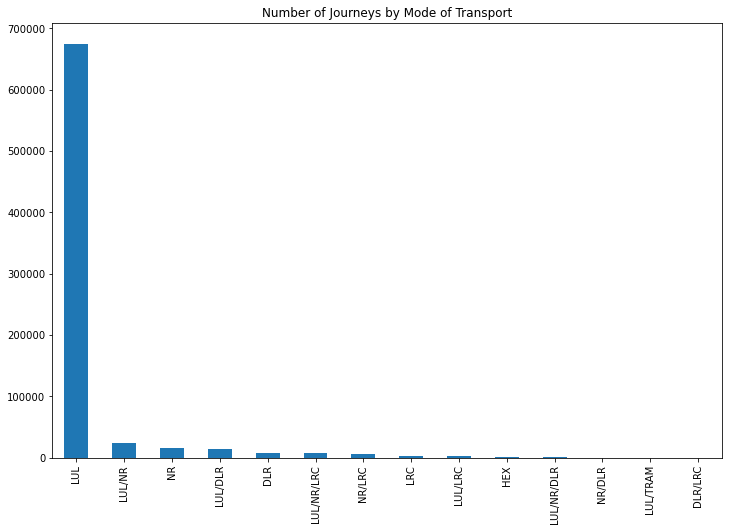

In [32]:
fig = plt.figure(figsize=[12,8])
plt.title('Number of Journeys by Mode of Transport')
complete['SubSystem'].value_counts().plot(kind='bar')

## Important Observation on 'complete' Dataframe
* LUL (Underground) is by far the most prominent mode of transport. This tells us that the 'complete' Dataframe is not indicative of all Oyster journeys, as it would appear that complete journey information is only available for LUL. We dropped all entries from other modes of transport, most notably Bus - which was by far the most popular mode of transport.
* It is therefore important to note that any predictions and conclusions we make from the 'complete' dataframe are only applicable to LUL journeys, and are not at all indicative of all Oyster journeys on the TFL network.
* For this reason, it is implied that any comments made henceforth on the 'complete' dataframe apply only to LUL journeys.

<AxesSubplot:title={'center':'Most Popular Underground Start Stations'}>

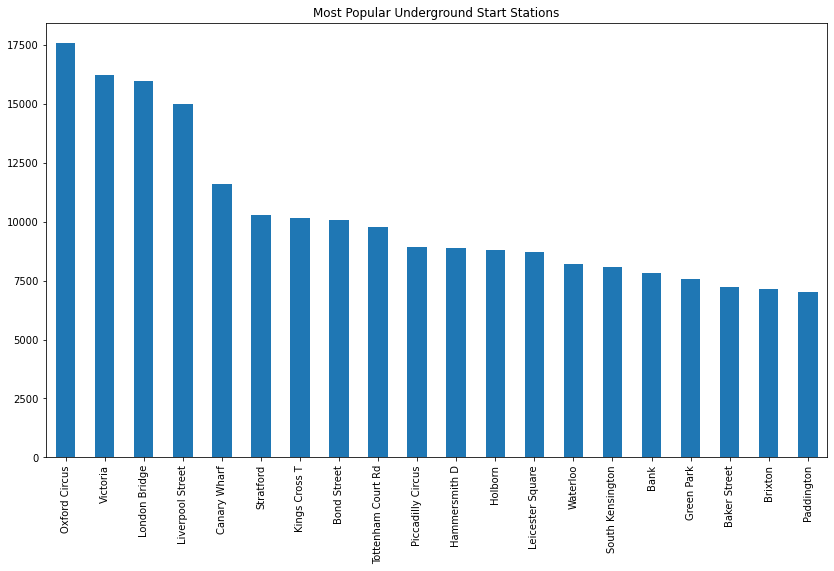

In [33]:
fig = plt.figure(figsize=[14,8])
plt.title('Most Popular Underground Start Stations')
complete['StartStn'].value_counts()[:20].plot(kind='bar')

<AxesSubplot:title={'center':'Most Popular Underground End Stations'}>

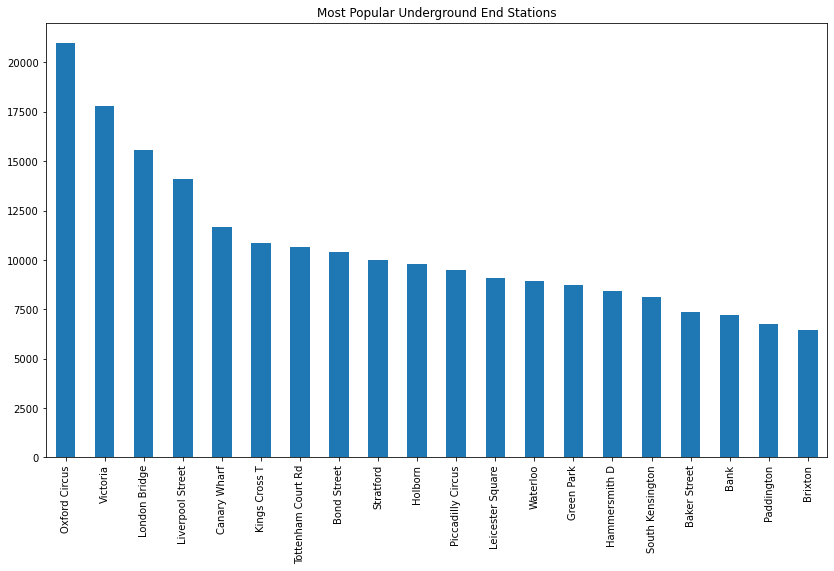

In [34]:
fig = plt.figure(figsize=[14,8])
plt.title('Most Popular Underground End Stations')
complete['EndStn'].value_counts()[:20].plot(kind='bar')

In [35]:
complete[['StartStn','EndStn']].sample(10)

,StartStn,EndStn
1807087,Homerton,Dalston Kingsland
2300922,Cannon Street,Knightsbridge
1131076,Stratford,Stonebridge Park
1519508,Queensbury,Wembley Park
1323267,London Bridge,Camden Town
493209,Liverpool Street,Golders Green
1745934,Colliers Wood,Tottenham Court Rd
104610,Gloucester Road,Northfields
856847,South Ealing,Clapham South
2051422,Cyprus,Shadwell DLR


## Comparing Start and End Stations
* Now I create a frequency plot for all stations with a hue of Start vs End Station
* This is my favourite visualisation as it took quite a bit of tinkering to find a good solution to create the hue 

In [41]:
from collections import OrderedDict

startstn = list(complete['StartStn'])
print(startstn)
endstn = list(complete['EndStn'])
df = pd.DataFrame(data={'StartStn':startstn,'EndStn':endstn})
df.head()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



,StartStn,EndStn
0,Goodge Street,Totteridge
1,Preston Road,Northwood
2,Holborn,Bounds Green
3,Earls Court,Pimlico
4,Victoria,Bethnal Green


In [39]:
# Create 'hue' column to use for plot

df['hue'] = 'Start' # set 'hue' to 'Start' for all Start stations

df['Stations'] = df['StartStn']
df_start = df[['Stations','hue']]
print(df_start)
df['hue'] = 'End'   # set 'hue' to 'End' for all End stations
df['Stations'] = df['EndStn']
df_end = df[['Stations','hue']]

                  Stations    hue
0            Goodge Street  Start
1             Preston Road  Start
2                  Holborn  Start
3              Earls Court  Start
4                 Victoria  Start
...                    ...    ...
759362            Waterloo  Start
759363   Notting Hill Gate  Start
759364    Leicester Square  Start
759365           Wood Lane  Start
759366  Tottenham Court Rd  Start

[759367 rows x 2 columns]


In [45]:
# Create order by value count

orderstart = df['StartStn'].value_counts()

startstnlist = orderstart.index.tolist()

orderend = df['EndStn'].value_counts()
endstnlist = orderend.index.tolist()

order = startstnlist+endstnlist

order = list(OrderedDict.fromkeys(order))

df_concat = pd.concat([df_start,df_end],ignore_index=True)
print(df_concat)

                Stations    hue
0          Goodge Street  Start
1           Preston Road  Start
2                Holborn  Start
3            Earls Court  Start
4               Victoria  Start
...                  ...    ...
1518729    Turnpike Lane    End
1518730  Fulham Broadway    End
1518731        Southgate    End
1518732     Baker Street    End
1518733             Oval    End

[1518734 rows x 2 columns]


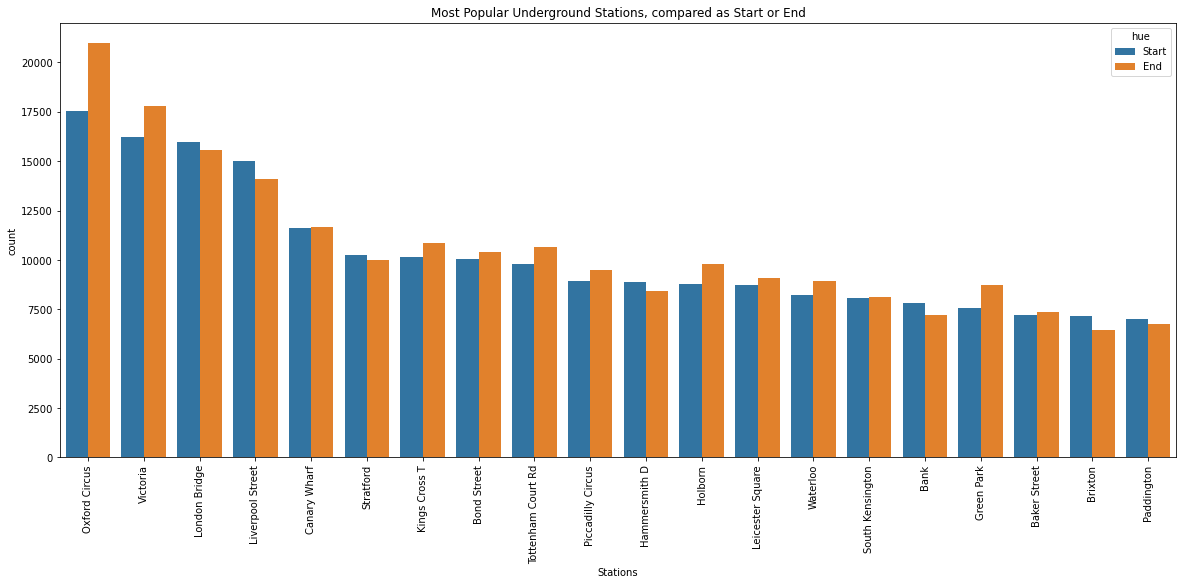

In [46]:
plt.figure(figsize=[20,8])
fig = sns.countplot(data=df_concat,x='Stations',order=order[:20],hue='hue')
plt.title('Most Popular Underground Stations, compared as Start or End')
fig.set_xticklabels(fig.get_xticklabels(), rotation=90);

### Most popular Underground stations (Start or End)
* Now let's look at the most popular underground stations, whether they are the start or end points of a journey

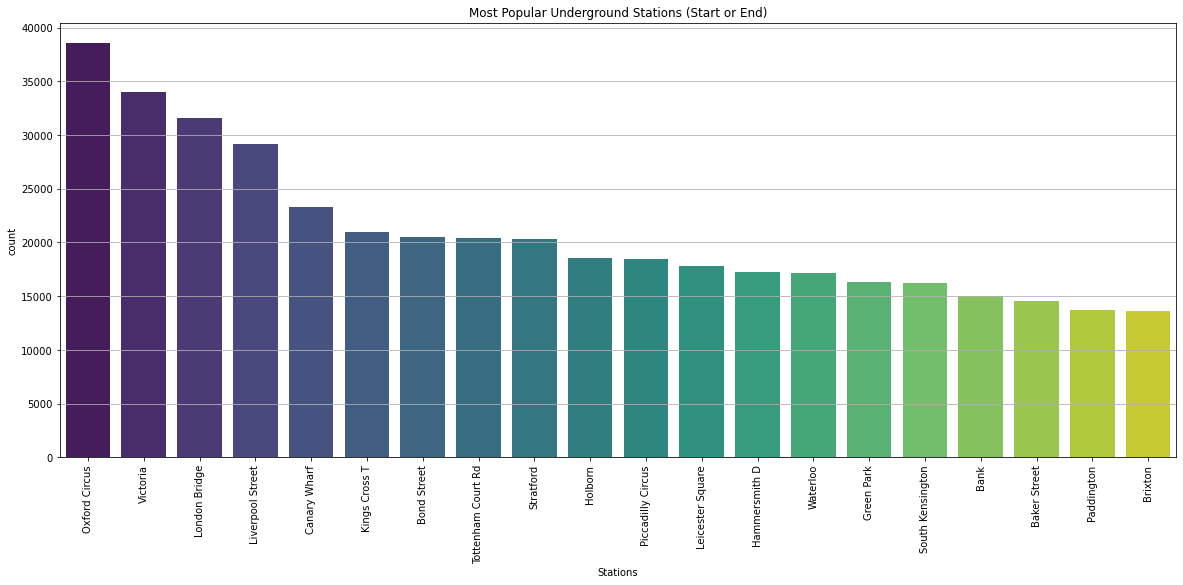

In [47]:
# Get order of all stations from df_concat
allstnlist = df_concat['Stations'].value_counts().index.tolist()
orderall = list(OrderedDict.fromkeys(allstnlist))

plt.figure(figsize=[20,8])
plt.grid()
plt.title('Most Popular Underground Stations (Start or End)')
fig = sns.countplot(x='Stations',data=df_concat,order=orderall[:20],palette='viridis')
fig.set_xticklabels(fig.get_xticklabels(), rotation=90);

## Journey Length Distribution
* Now let's investigate the distribution of journey lengths on the network

Text(0, 0.5, 'Percentage of total journeys')

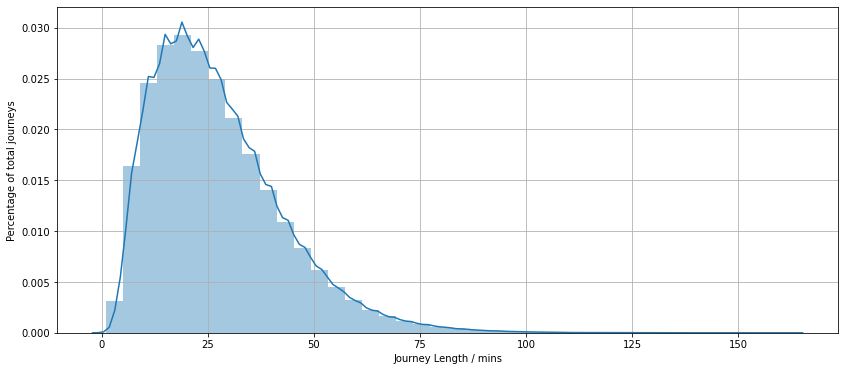

In [48]:
plt.figure(figsize=[14,6])
plt.grid()
ax = sns.distplot(complete['JourneyLength'],bins=40)
ax.set_xlabel('Journey Length / mins')
ax.set_ylabel('Percentage of total journeys')

* The distribution plot shows a positive skew
* We can see that the mean Journey Length is around 20 mins

## Compare days of week
* Now let's look at a frequency plot according to the day of the week

In [49]:
daysofweek = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

Text(0, 0.5, 'Number of journeys')

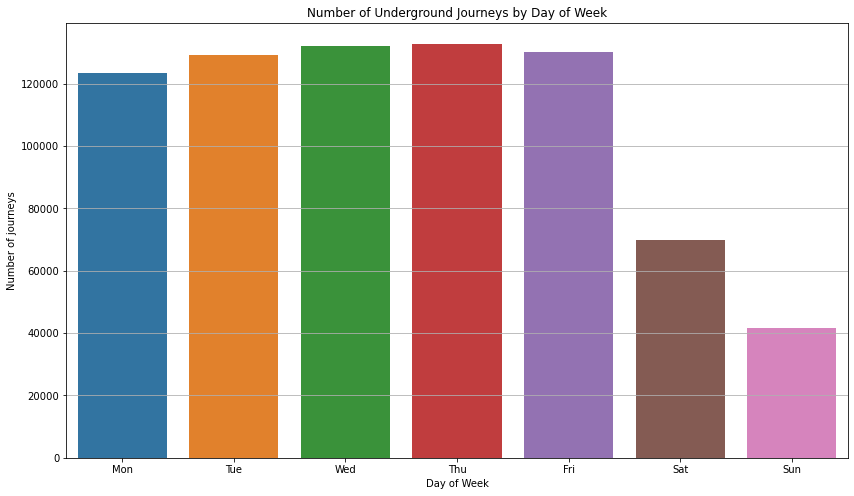

In [50]:
plt.figure(figsize=[14,8])
plt.grid()
sns.countplot(x='DOW',data=complete, order = daysofweek)
plt.title('Number of Underground Journeys by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of journeys')

As expected, we find most journeys happen on weekdays, with fewer on Saturdays and least on Sundays.

# Step 3: Preprocessing
* Now I will prepare data for modelling, creating logical variables and dropping redundant features

In [51]:
# Create logical variable of Daily Capping
complete['DailyCapping'] = pd.get_dummies(complete['DailyCapping'])['Y']

* Now I look at the different Final Product entries, to find outliers and erroneous entries

<AxesSubplot:>

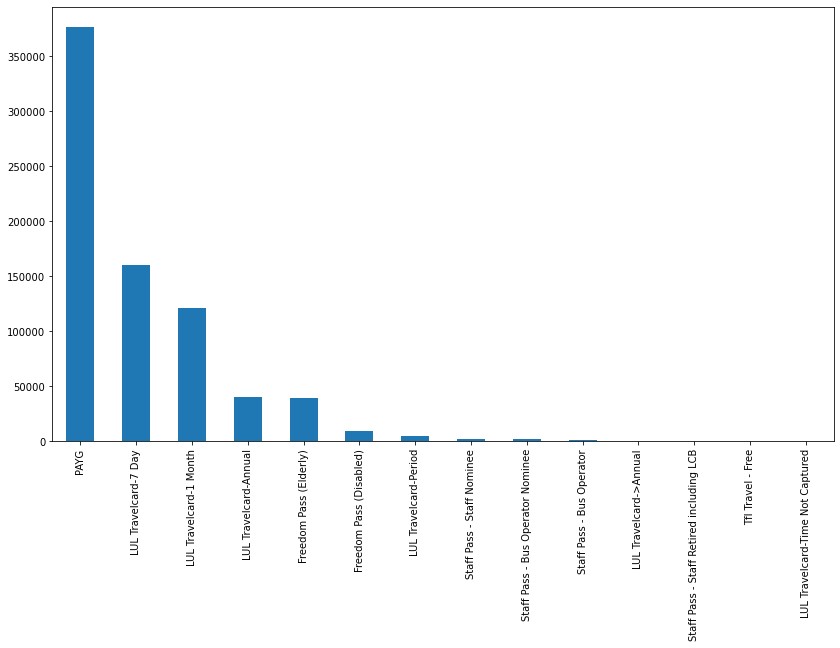

In [52]:
plt.figure(figsize=[14,8])
complete['FinalProduct'].value_counts().plot(kind='bar')

In [53]:
complete['FinalProduct'].value_counts()

PAYG                                        376020
LUL Travelcard-7 Day                        160291
LUL Travelcard-1 Month                      121245
LUL Travelcard-Annual                        40630
Freedom Pass (Elderly)                       39835
Freedom Pass (Disabled)                       9360
LUL Travelcard-Period                         4907
Staff Pass - Staff Nominee                    2606
Staff Pass - Bus Operator Nominee             1996
Staff Pass - Bus Operator                     1220
LUL Travelcard->Annual                         636
Staff Pass - Staff Retired including LCB       420
Tfl Travel - Free                              199
LUL Travelcard-Time Not Captured                 2
Name: FinalProduct, dtype: int64

In [54]:
complete[complete['FinalProduct'] == 'Tfl Travel - Free']

,DOWno,DOW,SubSystem,StartStn,EndStn,EntTime,ExTime,Zones,JourneyType,DailyCapping,FullFare,DiscountFare,FinalProduct,JourneyLength
56753,3,Tue,LUL,Gloucester Road,Hammersmith D,1003,1014,Z0110,TKT,0,0,0,Tfl Travel - Free,11
78555,6,Fri,LUL,West Acton,Latimer Road,1009,1029,Z0110,TKT,0,0,0,Tfl Travel - Free,20
96246,1,Sun,LUL,Hounslow East,Walthamstow Central,1015,1089,Z0110,TKT,0,0,0,Tfl Travel - Free,74
128455,3,Tue,LUL/DLR,Woolwich Arsenal DLR,Angel,1024,1078,Z0110,TKT,0,0,0,Tfl Travel - Free,54
130032,4,Wed,NR/LRC,Kenton,Wembley Central,1024,1040,Z0110,TKT,0,0,0,Tfl Travel - Free,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2562997,2,Mon,LUL,Snaresbrook,Woodford,981,997,Z0110,TKT,0,0,0,Tfl Travel - Free,16
2565739,7,Sat,LUL,Holland Park,White City,982,990,Z0110,TKT,0,0,0,Tfl Travel - Free,8
2566410,5,Thu,LUL,Snaresbrook,Woodford,982,997,Z0110,TKT,0,0,0,Tfl Travel - Free,15
2566866,6,Fri,LUL,Ealing Common,South Kensington,982,1011,Z0110,TKT,0,0,0,Tfl Travel - Free,29


* As we can see, 'LUL Travelcard->Annual' is an inconsistent entry matching 'LUL Travelcard-Annual'. I now rename these entries to be consistent with the rest of the data.
* I drop the two outliers where the travelcard time was not captured ('LUL Travelcard-Time Not Captured').
* It is unclear what is meant by 'Tfl Travelcard - Free'. My intuition is that this represents free journeys where passengers used 5-10 Zip oyster photocards. The Oyster card wikipedia page confirms that these Oyster cards were available in 2009, when the data was collected:
> "On 7 January 2008, Transport for London unveiled the Zip card, an Oyster photocard to be used by young people aged 18 years or under who qualify for free bus and tram travel within the capital, with effect from 1 June 2008."
[ [3] ](https://en.wikipedia.org/wiki/Oyster_card#Oyster_photocards) 

In [55]:
# Rename typo entries
complete['FinalProduct'].replace('LUL Travelcard->Annual','LUL Travelcard-Annual', inplace=True)

In [56]:
# Drop outlier entries where travelcard time period was missing
complete = complete[complete['FinalProduct'] != 'LUL Travelcard-Time Not Captured']

In [57]:
complete['FinalProduct'].value_counts()

PAYG                                        376020
LUL Travelcard-7 Day                        160291
LUL Travelcard-1 Month                      121245
LUL Travelcard-Annual                        41266
Freedom Pass (Elderly)                       39835
Freedom Pass (Disabled)                       9360
LUL Travelcard-Period                         4907
Staff Pass - Staff Nominee                    2606
Staff Pass - Bus Operator Nominee             1996
Staff Pass - Bus Operator                     1220
Staff Pass - Staff Retired including LCB       420
Tfl Travel - Free                              199
Name: FinalProduct, dtype: int64

# Conclusion
* From my analysis I can conclude that certain stations are under higher stress to accomodate passengers during rush hour. One such example is Oxford Circus.
* Most stations that experience high congestion are in Zone 1.
* It is advisable to find a method of sharing the passenger load that these congested stations carry with other nearby stations. Perhaps providing incentives for passengers to exit at a less congested station and complete their journey on foot or by bus, for example.
* I have cleaned up the data, performed EDA and some basic preprocessing to prepare it for modelling.
* I could now perform dimensionality reduction on the 'complete' dataframe, perhaps using PCA, to draw some more interesting conclusions. I may explore this possibility in future.